In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re, string, unicodedata
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [2]:
imdb_data = pd.read_csv('IMDB_Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)


(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
imdb_data.dropna(inplace=True)

In [6]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

In [7]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [8]:
def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    stopword_list = nltk.corpus.stopwords.words('english')
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [9]:
def clean_review(review):
    review = denoise_text(review)
    review = remove_special_characters(review)
    review = simple_stemmer(review)
    review = remove_stopwords(review)
    return review

In [11]:
imdb_data['review'] = imdb_data['review'].apply(clean_review)

# Split into train and test
train_reviews = imdb_data.review[:40000]
train_sentiments = imdb_data.sentiment[:40000]
test_reviews = imdb_data.review[40000:]
test_sentiments = imdb_data.sentiment[40000:]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [12]:
# Convert sentiment to numerical values
lb = LabelBinarizer()
sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

train_sentiments = sentiment_data[:40000]
test_sentiments = sentiment_data[40000:]

(50000, 1)


In [13]:
# TF-IDF Vectorization
tv = TfidfVectorizer(min_df=1e-5, max_df=1.0, use_idf=True, ngram_range=(1, 3))
tv_train_reviews = tv.fit_transform(train_reviews)
tv_test_reviews = tv.transform(test_reviews)

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)


Tfidf_train: (40000, 6983231)
Tfidf_test: (10000, 6983231)


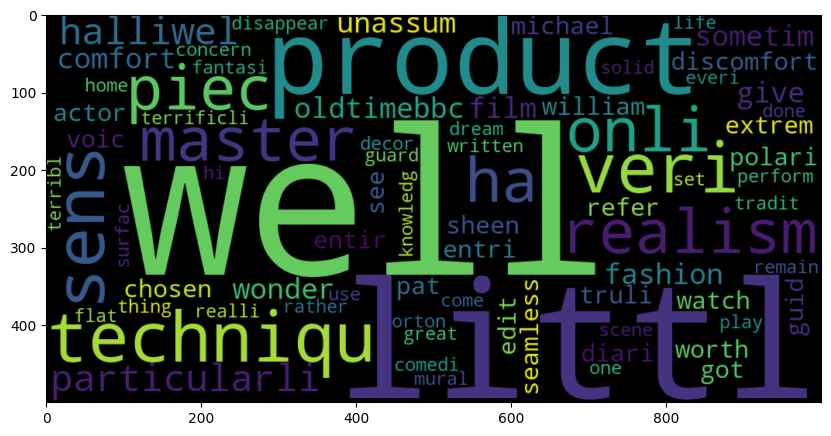

In [14]:
# Word cloud visualization
plt.figure(figsize=(10,10))
positive_text = train_reviews[1]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

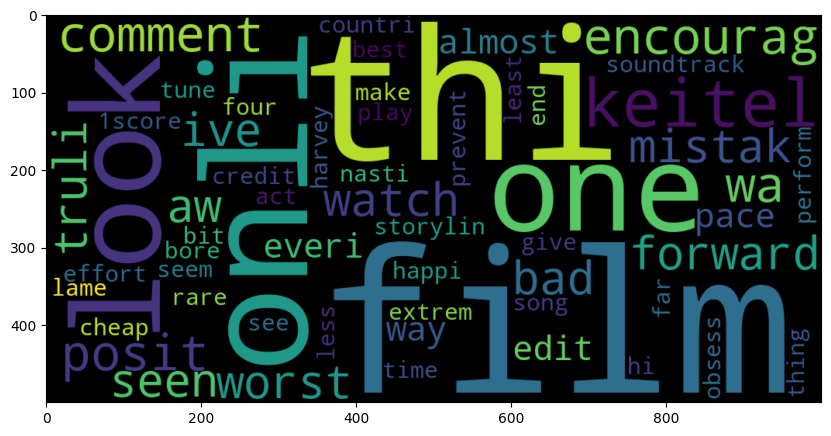

In [15]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text = train_reviews[8]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words, interpolation='bilinear')
plt.show()

In [16]:
# Model training
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print(lr_tfidf)

c:\Users\Sajee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [17]:
# Predictions
lr_tfidf_predict = lr.predict(tv_test_reviews)
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("lr_tfidf_score:", lr_tfidf_score)

lr_tfidf_score: 0.8873


In [18]:
# Classification report
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.89      0.89      0.89      4993
    Negative       0.89      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [19]:
# Confusion matrix
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
print(cm_tfidf)

[[4447  560]
 [ 567 4426]]


In [20]:
# Save the model and vectorizer for deployment
with open('model.pkl', 'wb') as f:
    pickle.dump(lr, f)
    
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tv, f)
    
with open('label_binarizer.pkl', 'wb') as f:
    pickle.dump(lb, f)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
